In [179]:
import pandas as pd
import numpy as np
import os, pickle
import json
data1=[]
rootdir = 'T20_matches'
cnt=0
for subdir, dirs, files in os.walk(rootdir):
    # print(dirs)
    # if(cnt>=50):
    #     break
    try: 
        for file in files:
            # print(cnt)
            if(file[-1]=='v'):
                continue
            # if(cnt>=50):
            #     break
            if file.endswith('1.pkl'):
                # print(os.path.join(subdir,"match_info.json"))
                # print(cnt)
                with open(os.path.join(subdir,file), 'rb') as f:
                    # print("here")
                    data1 = (pickle.load(f))
                    with open(os.path.join(subdir,"match_info.json")) as file:
                        match_info = json.load(file)
                        # print("here")
                    if cnt==0:
                        df1 = pd.DataFrame(data1,columns=['bowler', 'batsman', 'wickets', 'over', 'outcome'])
                        df1['batting_team'] = match_info['First Innings']
                        df1['bowling_team'] = match_info['Second Innings']
                        df1['venue'] = match_info['Stadium Name']
                        df1['toss_won'] = int(match_info['Toss Winner'] == match_info['First Innings'])
                        df1['runs'] = df1['outcome'].apply(custom_sum).cumsum() 
                        # print("df1.head()")
                    else:
                        dft = pd.DataFrame(data1,columns=['bowler', 'batsman', 'wickets', 'over', 'outcome'])
                        dft['batting_team'] = match_info['First Innings']
                        dft['bowling_team'] = match_info['Second Innings']
                        dft['venue'] = match_info['Stadium Name']
                        dft['toss_won'] = int(match_info['Toss Winner'] == match_info['First Innings'])
                        dft['runs'] = dft['outcome'].apply(custom_sum).cumsum() 
                        df1 = pd.concat([df1,dft],ignore_index=True)


                    cnt+=1
                    
    except: 
        pass

In [178]:
def custom_sum(x):
  """
  This function checks if the value is in the skip list and returns 0 if it is.
  Otherwise, it returns the value itself.
  """
  skip_values = [5, 7]  # Values to exclude from cumulative sum
  if x in skip_values:
    return 0
  else:
    return x



In [171]:
from tensorflow.keras.optimizers import Adam  # Or any other optimizer you're using


In [180]:
df1

,bowler,batsman,wickets,over,outcome,batting_team,bowling_team,venue,toss_won,runs
0,Finn,Smith,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,1
1,Finn,Gayle,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,1
2,Finn,Gayle,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,1
3,Finn,Gayle,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,1
4,Finn,Gayle,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,2
...,...,...,...,...,...,...,...,...,...,...
29628,Arafat,Nasir,4,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160
29629,Arafat,Shakib,4,20,7,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160
29630,Arafat,Ziaur,5,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,161
29631,Arafat,Nasir,5,20,4,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,165


In [181]:
cat_cols = ['bowler', 'batsman', 'batting_team', 'bowling_team', 'venue']
for category in cat_cols:
    df1[category] = pd.Categorical(df1[category])
    df1[category+"_idx"] = df1[category].cat.codes

df1

,bowler,batsman,wickets,over,outcome,batting_team,bowling_team,venue,toss_won,runs,bowler_idx,batsman_idx,batting_team_idx,bowling_team_idx,venue_idx
0,Finn,Smith,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,1,81,296,8,2,53
1,Finn,Gayle,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,1,81,102,8,2,53
2,Finn,Gayle,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,1,81,102,8,2,53
3,Finn,Gayle,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,1,81,102,8,2,53
4,Finn,Gayle,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,2,81,102,8,2,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29628,Arafat,Nasir,4,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160,14,216,1,5,33
29629,Arafat,Shakib,4,20,7,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160,14,285,1,5,33
29630,Arafat,Ziaur,5,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,161,14,356,1,5,33
29631,Arafat,Nasir,5,20,4,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,165,14,216,1,5,33


In [182]:
df2 = df1[['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx', 'bowling_team_idx', 'venue_idx', 'toss_won','runs', 'outcome']]

In [183]:
def create_sequences(df, max_len):
  """
  This function extracts sequences of a fixed length from a Pandas DataFrame 
  containing cricket match data and creates sequences with arrays of features.

  Args:
      df: A Pandas DataFrame containing cricket match data (e.g., batsman, bowler, outcome for each ball).
      max_len: The desired length of each sequence (number of balls).

  Returns:
      A numpy array of shape (num_sequences, max_len, features) containing sequences.
  """

  sequences = []
  for i in range(df.shape[0] - max_len + 1):  # Slide window approach
    sequence = []
    for j in range(i, i + max_len):
      # Access data for each ball using row indexing
      ball_data = df.iloc[j]
      # Create a numpy array of features for this ball
      features = np.array([ball_data[col] for col in df.columns if col not in ['index','bowler', 'batsman', 'batting_team', 'bowling_team', 'venue']])  # Exclude index column
      sequence.append(features)  # Append array of features to sequence
    sequences.append(sequence)

  # Convert sequences to numpy array (no reshape needed here)
  sequences = np.array(sequences)
  return sequences
def get_target_variable(sequence):
  """
  This function retrieves the target variable (outcome of the next ball) 
  corresponding to a sequence of balls.

  Args:
      sequence: A list representing a sequence of balls (features for each ball).

  Returns:
      The target variable (outcome of the next ball) encoded as needed.
  """
  # Assuming the outcome is the last element in the sequence (modify as needed)
  target_variable = sequence[-1][-1]
  # Encode the target variable (e.g., one-hot encoding for multi-class classification)
  # ... (your target variable encoding logic) ...
  return target_variable

In [187]:
sequences = create_sequences(df2, 10)
target_variables = []
for sequence in sequences:  # Function to create sequences of length max_len
    target_variables.append(get_target_variable(sequence)) 

In [112]:
sequences

array([[[ 81, 296,   0, ...,  53,   1,   1],
        [ 81, 102,   0, ...,  53,   1,   0],
        [ 81, 102,   0, ...,  53,   1,   0],
        ...,
        [ 62, 102,   0, ...,  53,   1,   1],
        [ 62, 296,   0, ...,  53,   1,   0],
        [ 62, 296,   0, ...,  53,   1,   0]],

       [[ 81, 102,   0, ...,  53,   1,   0],
        [ 81, 102,   0, ...,  53,   1,   0],
        [ 81, 102,   0, ...,  53,   1,   0],
        ...,
        [ 62, 296,   0, ...,  53,   1,   0],
        [ 62, 296,   0, ...,  53,   1,   0],
        [ 62, 296,   0, ...,  53,   1,   4]],

       [[ 81, 102,   0, ...,  53,   1,   0],
        [ 81, 102,   0, ...,  53,   1,   0],
        [ 81, 102,   0, ...,  53,   1,   1],
        ...,
        [ 62, 296,   0, ...,  53,   1,   0],
        [ 62, 296,   0, ...,  53,   1,   4],
        [ 62, 296,   0, ...,  53,   1,   0]],

       ...,

       [[  8, 216,   4, ...,  33,   1,   1],
        [  8, 285,   4, ...,  33,   1,   2],
        [  8, 285,   4, ...,  33,   1,   3

In [113]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

# Define parameters (replace with your values)
max_len = 10  # Maximum sequence length (number of balls)
num_features = 8  # Total number of features after encoding (replace with actual number)


In [188]:
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', value=-1)
padded_sequences

array([[[ 81, 296,   0, ...,   1,   1,   1],
        [ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        ...,
        [ 62, 102,   0, ...,   1,   3,   1],
        [ 62, 296,   0, ...,   1,   3,   0],
        [ 62, 296,   0, ...,   1,   3,   0]],

       [[ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        ...,
        [ 62, 296,   0, ...,   1,   3,   0],
        [ 62, 296,   0, ...,   1,   3,   0],
        [ 62, 296,   0, ...,   1,   7,   4]],

       [[ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   2,   1],
        ...,
        [ 62, 296,   0, ...,   1,   3,   0],
        [ 62, 296,   0, ...,   1,   7,   4],
        [ 62, 296,   0, ...,   1,   7,   0]],

       ...,

       [[  8, 216,   4, ...,   1, 147,   1],
        [  8, 285,   4, ...,   1, 149,   2],
        [  8, 285,   4, ...,   1, 152,   3

In [71]:
padded_sequences[0][-1]

array([36, 52,  0,  1,  8,  2, 24,  1,  1], dtype=int32)

In [189]:
X_train = []
y_train = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_train.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_train.append(target)


In [190]:
X_train = np.array(X_train)
X_train.shape

(29624, 10, 9)

In [191]:
y_train = np.array(y_train)
y_train.shape

(29624,)

In [192]:
n_train_time = int(0.8 * X_train.shape[0])
X_train ,X_test = X_train[:n_train_time], X_train[n_train_time:]
print(X_train.shape, X_test.shape)
y_train, y_test = y_train[:n_train_time], y_train[n_train_time:]
print(y_train.shape, y_test.shape)

(23699, 10, 9) (5925, 10, 9)
(23699,) (5925,)


In [193]:
y_train1= (pd.get_dummies(pd.DataFrame(y_train, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values)

In [194]:
y_test1= (pd.get_dummies(pd.DataFrame(y_test, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values) 

In [195]:
y_train1.shape

(23699, 8)

In [196]:
from keras.layers import Dropout
import matplotlib.pyplot as plt

In [197]:
pd.DataFrame(y_train).value_counts()

0
1    9375
0    7377
4    2538
2    1899
7    1330
6    1026
3     149
5       5
Name: count, dtype: int64

Epoch 1/100


/Users/rahul/miniconda3/envs/btp/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


741/741 - 6s - 8ms/step - accuracy: 0.4156 - loss: 1.5069 - val_accuracy: 0.4241 - val_loss: 1.4845
Epoch 2/100
741/741 - 5s - 6ms/step - accuracy: 0.4370 - loss: 1.4814 - val_accuracy: 0.4302 - val_loss: 1.4770
Epoch 3/100
741/741 - 5s - 6ms/step - accuracy: 0.4390 - loss: 1.4735 - val_accuracy: 0.4299 - val_loss: 1.4756
Epoch 4/100
741/741 - 5s - 6ms/step - accuracy: 0.4412 - loss: 1.4691 - val_accuracy: 0.4336 - val_loss: 1.4731
Epoch 5/100
741/741 - 5s - 6ms/step - accuracy: 0.4415 - loss: 1.4639 - val_accuracy: 0.4338 - val_loss: 1.4673
Epoch 6/100
741/741 - 5s - 6ms/step - accuracy: 0.4427 - loss: 1.4532 - val_accuracy: 0.4354 - val_loss: 1.4555
Epoch 7/100
741/741 - 4s - 6ms/step - accuracy: 0.4474 - loss: 1.4327 - val_accuracy: 0.4403 - val_loss: 1.4279
Epoch 8/100
741/741 - 5s - 6ms/step - accuracy: 0.4623 - loss: 1.3896 - val_accuracy: 0.4520 - val_loss: 1.3939
Epoch 9/100
741/741 - 4s - 6ms/step - accuracy: 0.4857 - loss: 1.3344 - val_accuracy: 0.4824 - val_loss: 1.3239
Epoc

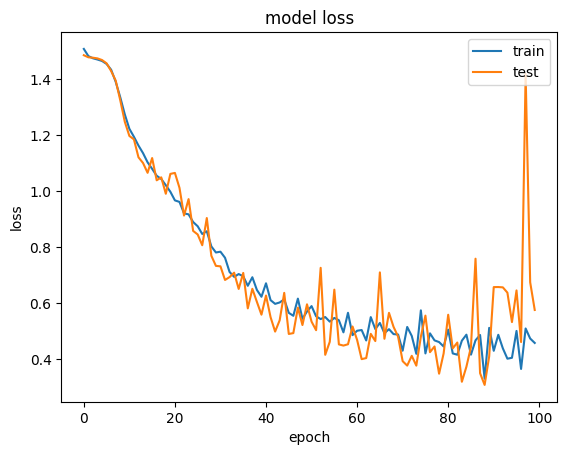

In [198]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))

#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(8, activation='softmax'))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit network
history = model.fit(X_train, y_train1, epochs=100, batch_size=32, validation_data=(X_test, y_test1), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [86]:
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

In [185]:
df_team1 = df2[df2['batting_team_idx'] == 0]
sequences = create_sequences(df_team1, 10)
target_variables = []
for sequence in sequences:  # Function to create sequences of length max_len
    target_variables.append(get_target_variable(sequence)) 

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', value=-1)
padded_sequences
X_train = []
y_train = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_train.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_train.append(target)
X_train = np.array(X_train)
y_train = np.array(y_train)
n_train_time = int(0.8 * X_train.shape[0])
X_train ,X_test = X_train[:n_train_time], X_train[n_train_time:]
print(X_train.shape, X_test.shape)
y_train, y_test = y_train[:n_train_time], y_train[n_train_time:]
y_train1= (pd.get_dummies(pd.DataFrame(y_train, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values)
y_test1= (pd.get_dummies(pd.DataFrame(y_test, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values) 



(3111, 10, 9) (778, 10, 9)


In [152]:
y_test1.shape

(778, 7)

Epoch 1/100


/Users/rahul/miniconda3/envs/btp/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


389/389 - 4s - 10ms/step - accuracy: 0.3815 - loss: 1.5960 - val_accuracy: 0.4023 - val_loss: 1.5408
Epoch 2/100
389/389 - 2s - 5ms/step - accuracy: 0.4008 - loss: 1.5494 - val_accuracy: 0.4139 - val_loss: 1.5313
Epoch 3/100
389/389 - 2s - 5ms/step - accuracy: 0.4079 - loss: 1.5389 - val_accuracy: 0.4010 - val_loss: 1.5263
Epoch 4/100
389/389 - 2s - 5ms/step - accuracy: 0.4188 - loss: 1.5298 - val_accuracy: 0.3997 - val_loss: 1.5348
Epoch 5/100
389/389 - 2s - 5ms/step - accuracy: 0.4131 - loss: 1.5232 - val_accuracy: 0.4075 - val_loss: 1.5327
Epoch 6/100
389/389 - 2s - 5ms/step - accuracy: 0.4221 - loss: 1.5207 - val_accuracy: 0.4126 - val_loss: 1.5226
Epoch 7/100
389/389 - 2s - 5ms/step - accuracy: 0.4201 - loss: 1.5186 - val_accuracy: 0.3985 - val_loss: 1.5229
Epoch 8/100
389/389 - 2s - 5ms/step - accuracy: 0.4262 - loss: 1.5154 - val_accuracy: 0.4126 - val_loss: 1.5273
Epoch 9/100
389/389 - 2s - 5ms/step - accuracy: 0.4198 - loss: 1.5093 - val_accuracy: 0.4036 - val_loss: 1.5280
Epo

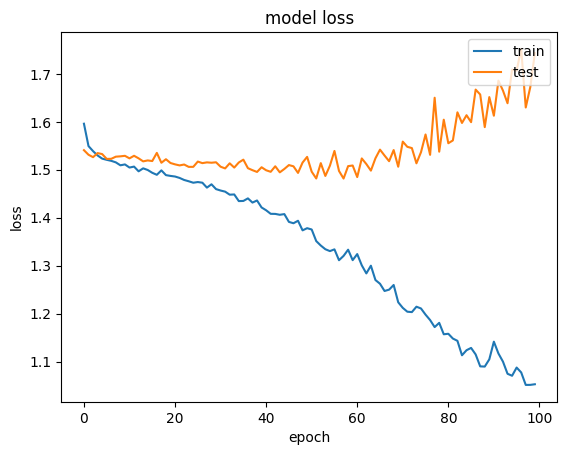

In [186]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))

#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
# model.add(LSTM(units=32))
# model.add(Dropout(0.2))

# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(7, activation='softmax'))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
optimizer = Adam(learning_rate=0.01)  # Replace 0.001 with your desired learning rate

# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit network
history = model.fit(X_train, y_train1, epochs=100, batch_size=8, validation_data=(X_test, y_test1), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
#DROP OUTCOME =5 remember important

In [87]:
yhat = model.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat))

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean squared error: 3.97


In [34]:
df1['bowler'].value_counts()

bowler
Broad         192
Dernbach      144
Malinga       135
Shakib        132
Razzak        132
             ... 
Waller          6
Woakes          6
Ziaur           6
Sajedul         6
du Plessis      2
Name: count, Length: 143, dtype: int64

In [6]:
match_info

{'Stadium Name': 'Trent Bridge, Nottingham',
 'Toss Winner': 'West Indies',
 'First Innings': 'West Indies',
 'Second Innings': 'England',
 'First Innings runs': '172',
 'Second Innings runs': '173',
 'First Innings Wickets': '4',
 'Second Innings Wickets': '3',
 'Winner': 'England'}